# 15 - Synthetic Control

## One Amazing Math Trick to Learn What can’t be Known

 Difference-In-Difference(DID)를 살펴보니 Porto Alegre와 Florianopolis의 2개 도시에서 여러 고객 데이터가 있었어요. 해당 데이터는 2개의 다른 시점에 걸쳐져 있습니다: 고객 예금을 늘리기 위해 Porto Alegre에서 마케팅 개입(intervention)이 이루어지기 전과 후로 서로 다른 시점에 걸쳐져 있었어요. 처치(Treatment) 효과를 추정하기 위해 DID 추정량과 표준 오차를 제공하는 회귀 분석을 진행했어요.

 이 경우, 데이터가 세분화되었기 때문에 많은 샘플이 있었습니다. 하지만 도시 수준에서 집계된 데이터만 있으면 어떻게 될까요? 예를 들어, 개입 전후에 두 도시의 평균 예금 수준만 있다고 가정해봅시다.

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

여전히 DID 추정량을 계산할 수 있습니다.

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

그러나 여기에서 샘플 크기는 4이며, 이는 DID 모델의 매개변수 개수이기도 합니다. 이 경우 표준오차가 잘 정의되어 있지 않은데 어떻게 해야 할까요? 또 다른 문제는 Florianopolis가 우리가 원하는 만큼 Porto Alegre와 유사하지 않을 수 있다는 것이죠. 예를 들어, Florianopolis는 아름다운 해변과 여유로운 사람들로 유명하고 Porto Alegre는 바베큐와 초원으로 더 알려져 있어요. 여기서 문제는 적절한 통제 그룹을 사용하고 있는지 확실히 알 수 없다는 것입니다.

이를 해결하기 위해 [**"지난 몇 년 동안 정책 평가 문헌에서 가장 중요한 혁신"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3)으로 알려진 Synthetic Control 방법을 사용하려고 해요. Synthetic Control은 단순하지만 강력한 아이디어를 기반으로 해요. 해당 방법을 이용한다면, 굳이 처치를 받은 집단과 가장 유사한 처치를 받지 않은 단독 그룹을 따로 찾을 필요가 없습니다. 대신, 처치를 받지 않은 여러 집단의 조합을 통해, 효과적으로 가상의 통제 집단(Synthetic Control)을 만들 수 있습니다. Synthetic Control은 매우 효과적이면서도 직관적이어서 과학 저널이 아닌 [워싱턴 포스트](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/)에 기사도 실렸어요.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

실제로 보려면 담배 세금이 소비에 미치는 영향을 추정하는 문제를 고려합시다. 조금 더 알아보자면, 이것은 경제학에서 오랫동안 논의되어온 질문입니다. 한 쪽은 세금이 담배 가격을 상승시켜 수요를 낮출 것이라고 주장합니다. 반대쪽은 담배가 중독을 유발하기 때문에 가격이 변동한다고 해서 수요가 크게 변하지 않는다고 주장 합니다. 경제적 측면에서 담배에 대한 수요는 가격에 비탄력적이며, 세금 인상은 흡연자의 비용으로 정부 수입을 늘리는 방법일 뿐입니다. 문제를 해결하기 위해 이 문제 관련 일부 미국 데이터를 살펴보겠습니다.

1988년 캘리포니아는 [발의안 제 99호](https://en.wikipedia.org/wiki/1988_California_Proposition_99)로 잘 알려진 유명한 담배세 및 건강 보호법을 통과시켰습니다. “이 법안의 주요 효과는 캘리포니아 내 담배 판매에 대해 한 갑당 25센트의 주 소비세를 부과하는 것이며, 시가 및 씹는 담배와 같은 기타 상업용 담배 제품의 소매 판매에도 거의 동일한 소비세를 부과하는 것입니다. 담배 판매에 대한 추가 제한 사항에는 청소년이 접근할 수 있는 공공 장소에서 담배 자판기 사용 금지, 단일 담배 개별 판매 금지 등이 있습니다. 이 법으로 발생한 수익은 다양한 환경 및 건강 관리 프로그램과 금연 광고에 사용되었습니다.”

그 효과를 평가하기 위해 우리는 여러 주에서 몇 년 동안 담배 판매에 대한 데이터를 수집할 수 있습니다. 우리의 경우 39개 주에서 1970년부터 2000년까지의 데이터를 얻었습니다. 다른 주에는 유사한 담배 규제 프로그램이 있었고 분석에서는 제외되었습니다. 다음은 우리 데이터의 모습입니다.

In [ ]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

state  year     cigsale   retprice  california  after_treatment
62      3  1970  123.000000  38.799999        True            False
63      3  1971  121.000000  39.700001        True            False
64      3  1972  123.500000  39.900002        True            False
65      3  1973  124.400002  39.900002        True            False
66      3  1974  126.699997  41.900002        True            False

캘리포니아가 3위인 주 index로 `state`값을 가집니다. 공변량은 담배 소매 가격인 `retprice` 및 담배 한갑의 1인당 판매량인 `cigsale` 입니다. 우리의 관심 결과 변수는 입니다 `cigsale` 입니다. 마지막으로 캘리포니아 주와 사후 개입 기간을 알리는 부울 도우미 변수가 있습니다. 시간 경과에 따라 캘리포니아 및 기타 주의 담배 판매량을 표시하는것이 우리가 얻고자 하는 것입니다.

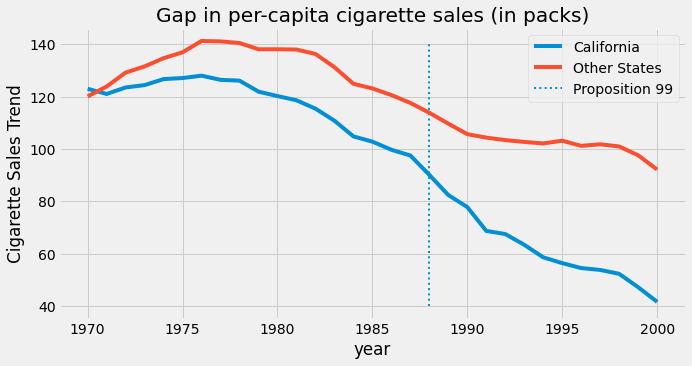

In [ ]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

우리가 데이터를 가지고 있는 동안, 캘리포니아 사람들은 분명히 전국 평균보다 담배를 덜 샀습니다. 또한 1980년대 이후 담배소비의 움직임이 감소하고 있는 것으로 보입니다. 발의안 제 99호 이후 캘리포니아의 감소 추세가 다른 주에 비해 가속화된 것처럼 보이지만 확실하다고 말할 순 없습니다. 그것은 그냥 그래프를 살펴봄으로써 얻은 추측일 뿐입니다.

발의안 제 99호가 담배 소비에 영향을 미쳤는지 여부에 답하기 위해, 사전 개입 기간을 사용하여 Synthetic Control을 구축할 것입니다. 우리는 다른 주를 결합하여 **캘리포니아의 추세와 매우 유사한 가짜 주를 건설할 것입니다**. 그런 다음, 이 Synthetic Control이 개입 후 어떻게 작동하는지 볼 것입니다.

## We have Time

문제를 좀 더 공식적으로 만들기 위해 $J+1$ 집단이 있다고 가정합니다. 일반성을 잃지 않고 집단 1이 개입의 영향을 받는 장치라고 가정합니다. 집단들 $j=2,...,J+1$는 우리가 "donor pool"이라고 언급되는 처치되지 않은 집단의 집합입니다. 또한 우리가 가지고 있는 데이터가 개입하기 전의 기간 $T_0$을 포함하여 T 기간에 걸쳐 있다고 가정합니다. 각 집단 j와 각 시간 t에 대해 결과 $Y_{jt}$를 관찰합니다. 각 집단 j와 기간 t에 대해 개입 없이 잠재적인 결과인 $Y^N_{jt}$와 개입으로 인한 잠재적인 결과인 $Y^I_{jt}$를 정의합니다.

그런 다음 $t>T_0$에 대한 시간 t에서 처치 집단 $j=1$에 대한 효과는 다음과 같이 정의됩니다.

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

집단 $j=1$은 처치된 것이기 때문에 $Y^I_{jt}$ 집단은 사실이지만 $Y^N_{jt}$는 아닙니다. 문제는 어떻게 $Y^N_{jt}$를 추정하는가입니다. 처치 효과가 기간별로 어떻게 정의되는지 주목하십시오. 즉, 시간에 따라 달라질 수 있습니다. 즉각적일 필요는 없습니다. 축적되거나 소멸될 수 있습니다. 그림으로 표현하자면, 처치효과를 추정하는 문제는 **처치되지 않았다면 $j=1$ 집단의 결과에 어떤 일이 일어났을지를 추정**하는 문제로 여겨집니다.

![img](data/img/synth-control/synth_img.png)

$Y^N_{jt}$를 추정하기 위해, 우리는 donor pool의 집단 조합이 처치되지 않은 집단보다 처치된 집단의 특성에 훨씬 더 가깝다는 것을 기억합니다. 따라서 Synthetic Control은 대조군 범위에 있는 집단의 가중 평균으로 정의됩니다. 가중치 $\pmb{W}=(w_2, ..., w_{J+1})$가 주어졌을 때, $Y^N_{jt}$의 Synthetic Control 추정치는 아래와 같습니다.

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

이 모든 수학이 머리를 아프게 한다면 혼자가 아닙니다. 하지만 걱정마요. 더 직관적으로 만들 수 있는 예제가 많이 있습니다. 이번에는, 회귀를 거꾸로 수행하는 방법으로 Synthetic Control에 대해 생각하고 싶습니다. 우리가 알고 있듯이 선형 회귀는 변수의 가중 평균으로 예측을 얻는 방법이기도 합니다. 이제 각 변수가 일정 기간 동안 더미인 DID 예제와 같은 회귀에 대해 생각해 보십시오. 이 경우 회귀는 다음과 같은 행렬 곱으로 나타낼 수 있습니다.

![img](data/img/synth-control/regr_time.png)

Synthetic Control의 경우 집단이 많지 않지만 기간은 많습니다. 그래서 우리가 하는 일은 입력 행렬을 뒤집는 것입니다. 그런 다음 집단은 "변수"가 되고 다음 행렬 곱셈과 같이 집단의 가중 평균으로 결과를 나타냅니다.

![img](data/img/synth-control/regr_space.png)

기간당 하나 이상의 피쳐이 있는 경우 이와 같은 피쳐를 쌓을 수 있습니다. 중요한 것은 회귀가 다른 집단을 사용하여 처치된 집단 1을 "예측"하려고 하도록 만드는 것입니다. 이런 식으로, 우리는 우리가 원하는 이 근접성을 달성하기 위해 최적의 방법으로 가중치를 선택할 수 있습니다. 다른 중요도를 부여하기 위해 피쳐를 다르게 확장할 수도 있습니다.

![img](./data/img/synth-control/regr_space_x.png)

따라서 Synthetic Control을 선형 회귀로 볼 수 있다면 OLS로 가중치를 추정할 수 있다는 의미이기도 합니다. 그렇죠? 네! 지금 해보죠.


## Synthetic Control as Linear Regression

![img](./data/img/synth-control/allways.png)

Synthetic Control로 처치 효과를 추정하기 위해 개입 기간 전에 처치된 집단과 유사한 "가짜 집단"을 구축하려고 합니다. 그런 다음 이 "가짜 집단"이 개입 후 어떻게 작동하는지 볼 것입니다. Synthetic Control과 모방한 집단의 차이는 처치 효과입니다.

선형 회귀로 이를 수행하기 위해 OLS를 사용하여 가중치를 찾습니다. 우리는 사전 개입 기간 동안 donor pool에 있는 집단의 가중 평균과 처치된 집단 사이의 거리의 제곱을 최소화할 것입니다.

그렇게 하려면 가장 먼저 집단(우리의 경우 주)을 열로 변환하고 시간을 행으로 변환해야 합니다. 우리는 `cigsale` 와 `retprice` 2개의 피쳐을 가지고 있기 때문에, 위의 그림과 같이 겹겹이 쌓을 것입니다. 우리는 개입 전 기간에 캘리포니아와 매우 유사한 Synthetic Control을 구축하고 개입 후 기간에 어떻게 행동하는지 확인할 것입니다. 이러한 이유로 사전 개입 기간만 선택하는 것이 중요합니다. 여기에서 피쳐는 비슷한 scale에 있는 것 같으므로 아무 조치도 취하지 않습니다. 피쳐가 하나는 천분의 일이고 다른건 십진수로 서로 다른 scale을 가진다면 차이를 최소화할 때 더 큰 피쳐가 가장 중요합니다. 이를 방지하려면 먼저 크기를 조정하는 것이 중요합니다.

In [ ]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

이제 Y 변수를 캘리포니아주로 정의하고 X를 다른 주로 정의할 수 있습니다.

In [ ]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

그런 다음 회귀를 실행합니다. 절편을 갖는 것은 모든 행이 1인 다른 상태를 추가하는 것과 같습니다. 그렇게 하셔도 되는데, 더 복잡한 것 같아서 그냥 생략하겠습니다. 회귀 분석에서는 처치된 집단과 donor pool의 집단 사이의 제곱 차를 최소화하는 가중치 집합을 반환합니다.

In [ ]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

이 가중치는 Synthetic Control을 구축하는 방법을 보여줍니다. 주 1의 결과에 -0.436, 주 2의 결과에 -1.038, 주 4의 결과에 0.679를 곱하는 식입니다. Pool에 있는 주의 행렬과 가중치 간의 곱을 사용하여 이를 얻을 수 있습니다.

In [ ]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

이제 Synthetic Control이 있으므로 캘리포니아 주의 결과 변수를 사용하여 시각화 수 있습니다.

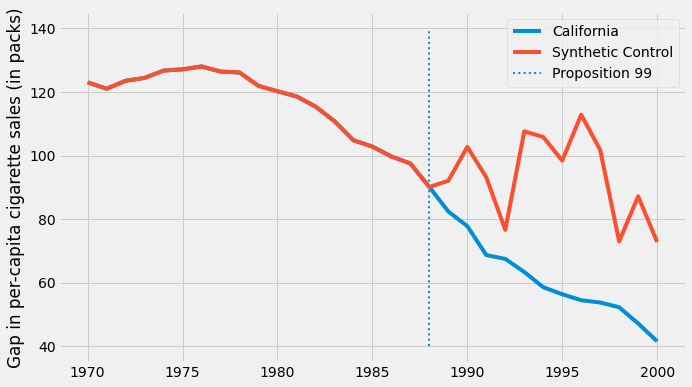

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

그래요… 뭔가 이상한 것 같아요. 이 그림에서 당신의 시선을 사로잡는 것은 무엇입니까? 첫째, 개입 후 Synthetic Control이 캘리포니아보다 담배 판매량이 더 많습니다. 이는 개입이 담배 수요를 낮추는 데 성공적이라는 것을 얘기합니다. 둘째, 사전 개입 기간이 어떻게 완벽하게 맞춰졌는지 확인하십시오. Synthetic Control은 캘리포니아 주와 정확히 일치할 수 있습니다. 이것은 Synthetic Control 모델이 데이터에 과적합되고 있다는 신호입니다. 또 다른 징후는 개입 후 Synthetic Control의 결과 변수에 큰 분산이 있다는 것입니다. 매끄러운 패턴을 따르지 않는지 확인하십시오. 오히려, 오르락내리락 합니다.

![img](./data/img/synth-control/out-of-sample.png)

왜 이런 일이 일어나는지 생각해보면, donor pool에 38개 주가 있다는 것을 기억하세요. 따라서 우리의 선형 회귀에는 전처리 pool이 가능한 한 비슷하게 처치와 일치하도록 예측하기 위해 사용할 38개의 매개변수가 있습니다. 이것은 T가 크더라도 N도 큰 경우이므로 선형 회귀 모델에 너무 많은 유연성을 제공합니다. 정규화된 모델에 익숙하다면 Ridge 또는 Lasso 회귀를 사용하여 이 문제를 해결할 수 있습니다. 여기에서는 과적합을 방지하는 또 다른 전통적인 방법을 살펴보겠습니다.

## Don't Extrapolate

아래 표와 같은 데이터가 있고 제어 집단의 선형 조합을 사용하여 처치된 집단를 재현하는 Synthetic Control을 구축하라는 요청을 받았다고 가정합니다.

|unit|sales|price|
|--|--|--|
|control 1|8|8|
|control 2|8|4|
|control 3|4|5|
|treated  |2|10|

일치시킬 수 있는 집단은 3개이고 속성은 2개뿐이므로 이 문제에 대한 정확한 솔루션은 여러 가지가 있지만 좋은 방법은 첫 번째 컨트롤에는 2.25를 곱하고 두 번째 컨트롤에는 -2를 곱하고 둘 다 더하는 것입니다. 두 번째 곱셈이 -16의 매출과 -8의 가격을 가진 가짜 단위를 생성하는 방법에 주목하십시오. 음의 가격과 판매는 거의 불가능하기 때문에 이 곱셈은 control 2 집단을 의미가 없는 데이터 영역으로 추정하는 것입니다. 첫 번째 곱셈은 판매와 가격이 18인 지역으로 첫 번째 단위를 가져오기 때문에 추정치이기도 합니다. 이 수치들은 데이터에 있는 모든 것보다 훨씬 높으므로 외삽합니다.

이것이 회귀가 Synthetic Control을 생성하도록 요청할 때 수행하는 작업입니다. 외삽은 기술적으로 잘못된 것은 아니지만 실제로는 위험합니다. 우리는 우리가 본 적이 없는 데이터가 우리가 가진 데이터처럼 행동한다고 ​​가정하고 있습니다.

더 안전하게 플레이하는 한 가지 방법은 보간만 수행하도록 Synthetic Control을 제한하는 것입니다. 그렇게 하기 위해 가중치를 양수로 제한하고 합을 1로 제한합니다. 이제 Synthetic Control은 donor pool에 있는 집단의 Convex combination이 됩니다. 보간을 수행할 때 아래 그림과 같이 처치되지 않은 집단으로 정의된  convex hull에 처치된 집단를 투영합니다.

![img](data/img/synth-control/extrapolation.png)

여기서 두 가지를 주목하십시오. 첫째, 보간은 이 경우 처차된 집단의 완벽한 일치를 만들 수 없습니다. 가장 적은 판매량과 가장 높은 가격을 가진 집단이 취급되기 때문이다. Convex combinations은 control 집단 사이에 있는 피쳐들만 정확하게 복제할 수 있습니다. 주의해야 할 또 다른 사항은 보간이 희박하다는 것입니다. 우리는 convex hull의 벽에 처치된 집단을 투영할 것이며 이 벽은 몇 개의 집단으로만 정의됩니다. 이러한 이유로 보간은 많은 집단에 가중치 0을 할당합니다.

이것은 일반적인 아이디어입니다. 이제 조금 공식화해 보겠습니다. Synthetic Control은 여전히 ​​다음과 같이 정의됩니다.

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

하지만 지금, 우리는 최소화하는 가중치 $\pmb{W}=(w_2, ..., w_{J+1})$를 사용할 것입니다.

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

$w_2, ..., w_{J+1}$는 양수이고 합이 1이라는 제한을 받습니다. 처리된 대조군과 Synthetic Control 간의 차이를 최소화할 때 각 변수의 중요성을 반영한다는 점에 주의하세요.

$v$들이 다르면 최적의 가중치가 달라집니다. $V$를 선택하는 한 가지 방법은 각 변수가 평균 0과 단위 분산을 갖도록 만드는 것입니다. 더 복잡한 방법은 예측하는 데 도움이 되는 변수가 더 높은 중요성을 갖도록 하는 방식으로 $Y$ 를 선택하는 것입니다. 우리는 코드를 단순화하기 때문에 각 변수에 대해 동일한 중요성을 부여할 것입니다.

이를 구현하려면 먼저 위의 손실 함수를 정의합니다.

In [ ]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

모든 피쳐에 대해 동일한 중요도를 사용하기 때문에 $v$를 걱정할 필요가 없습니다.

이제 최적의 가중치를 얻기 위해 scipy의 2차 프로그래밍 최적화를 사용할 것입니다. 우리는 가중치를 1로 합산하도록 제한할 것입니다.

```python 
lambda x: np.sum(x) - 1
```

또한 최적화 범위를 0과 1 사이로 설정합니다.

In [ ]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

이것을 구현하면 Synthetic Control을 정의하는 가중치를 얻습니다.



In [ ]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

이 가중치를 사용하여 주 1,2 와 3에 0을 곱하고 주 4에 0.0852를 곱하는 방식입니다. 우리가 예측한 대로 가중치가 얼마나 희박한지 보세요. 또한 모든 가중치의 합은 1이고 0과 1 사이에 있어 convex combination 제약 조건을 충족합니다.

이제 Synthetic Control을 얻기 위해 이전에 회귀 가중치를 사용하여 했던 것과 똑같은 상태로 가중치를 곱할 수 있습니다.

In [ ]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

지금 Synthetic Control의 결과를 플롯하면 훨씬 부드러운 추세를 얻을 수 있습니다. 또한 사전 개입 기간에 Synthetic Control은 더 이상 처치된 것을 정확하게 재현하지 않습니다. 이것은 우리가 과적합되지 않았음을 나타내므로 좋은 신호입니다.

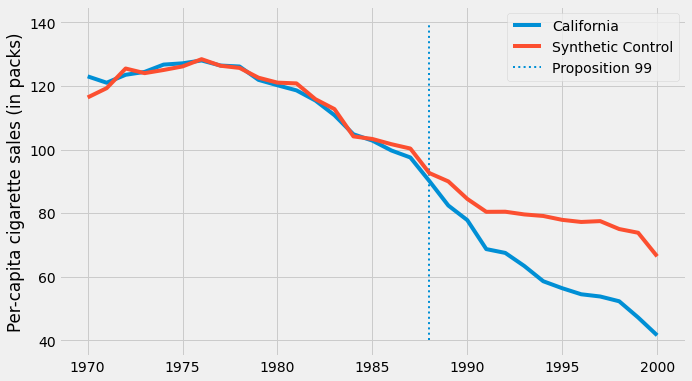

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

Synthetic Control을 사용하여 처치 효과와 Synthetic Control 결과 간의 차이로 처치 효과를 추정할 수 있습니다.



$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

우리의 경우, 그 효과는 시간이 지날수록 점점 더 커집니다.

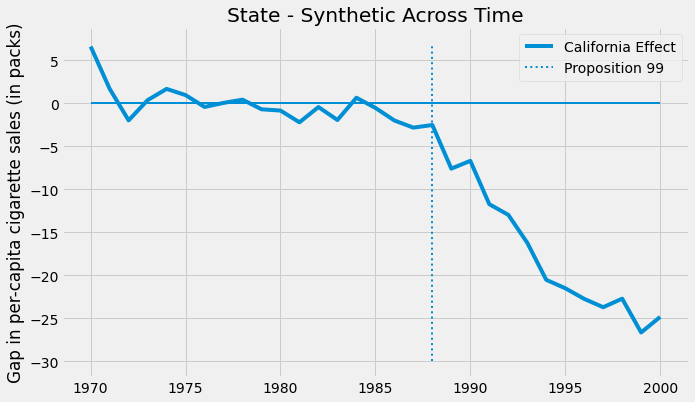

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

2000년까지 발의안 제 99호가 담배 판매량을 25갑이나 줄인 것 같습니다. 그것은 매우 멋집니다. 하지만 스스로에게 물어볼 것이 있습니다. 통계적으로 유의한지 어떻게 알 수 있습니까?

## Making Inference

우리의 표본 크기(39개)는 매우 작기 때문에, 무작위 운 때문이 아니라 결과가 통계적으로 유의한지 알아낼 때 좀 더 합리적이어야 합니다. 여기서는 Fisher's Exact Test의 개념을 사용합니다. 직관은 매우 간단합니다. 우리는 처치된 것을 치환하고 철저히 통제합니다. 처치된 집단이 하나만 있기 때문에 각 집단은 처치된 것으로 간주하고 다른 칩단은 통제된 것으로 간주합니다.

|iteration|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

결국 우리는 각 주에 대해 하나의 Synthetic Control 및 효과 추정치를 갖게 됩니다. 그래서 이것이 하는 것은 처치가 실제로 캘리포니아가 아닌 다른 주에서 발생했다고 가정하고 일어나지 않은 이 처치에 대한 예상 효과가 무엇인지 확인하는 것입니다. 그 뒤, 캘리포니아의 처치가 다른 가짜 처치에 비해 충분히 큰지 비교합니다. 실제로 치료를 받지 않은 주들에 대해 일단 처치를 받은 것 처럼 가정하면 유의미한 처치 효과를 찾을 수 없다는 아이디어입니다.

이것을 구현하기 위해 input state를 가지고 해당 주에 대한 Synthetic Control를 추정하는 이 함수를 만들었습니다. 이 함수는 주에 대한 열, 연도별 열, 시가 판매 결과 `cigsale` 열 및 해당 주에 대한 합성 결과를 포함하는 데이터 프레임을 반환합니다.

In [ ]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

다음은 첫 번째 주에 적용했을 때의 결과입니다.

In [ ]:
synthetic_control(1, cigar).head()

state  year     cigsale  after_treatment   synthetic
0      1  1970   89.800003            False   95.029419
1      1  1971   95.400002            False   99.118199
2      1  1972  101.099998            False  101.881329
3      1  1973  102.900002            False  103.938655
4      1  1974  108.199997            False  107.038474

모든 주에 대한 결과를 얻기 위해 8개 프로세스에 걸쳐 계산을 병렬화합니다. 당신 컴퓨터의 코어수에 따라 수를 조정할 수 있습니다. 이 코드는 위와 같은 데이터 프레임 목록을 반환합니다.

In [ ]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [ ]:
synthetic_states[0].head()

state  year     cigsale  after_treatment   synthetic
0      1  1970   89.800003            False   95.029419
1      1  1971   95.400002            False   99.118199
2      1  1972  101.099998            False  101.881329
3      1  1973  102.900002            False  103.938655
4      1  1974  108.199997            False  107.038474

모든 주에 대한 Synthetic Control을 사용하여 모든 주에 대한 합성 상태와 실제 상태 사이의 간격을 추정할 수 있습니다. 캘리포니아의 경우 이것이 처치 효과입니다. 다른 주에서는 플라시보 효과처럼 처치가 실제로 일어나지 않은 Synthetic Control 처치 효과를 추정합니다. 캘리포니아 처치 효과와 함께 모든 플라시보 효과를 플롯하면 다음 그림을 얻습니다.

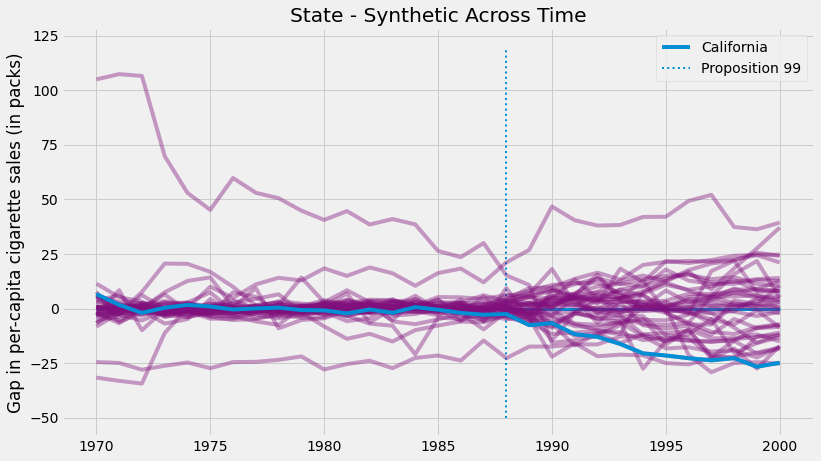

In [ ]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

이 수치의 두 가지 측면이 눈에 띕니다. 첫째, 개입 후의 분산이 개입 전의 분산보다 높음을 알 수 있다. Synthetic Control는 사전 개입 기간의 차이를 최소화하도록 설계되었으므로 이는 예상된 것입니다. 또 다른 흥미로운 측면은 사전 개입 기간에도 잘 맞지 않는 집단이 있다는 것입니다. 이 또한 가능합니다. 예를 들어, 일부 주에서 담배 소비량이 매우 높은 경우 다른 주에서 convex combination은 절대 일치하지 않습니다.

이러한 집단은 적합하지 않으므로 분석에서 제거하는 것이 좋습니다. 객관적으로 수행하는 한 가지 방법은 사전 개입 오류에 대한 임계값을 설정하는 것입니다.

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

높은 오류가 있는 해당 집단를 제거합니다. 이렇게 진행해서 같은 그림을 그리면 이렇게 됩니다.

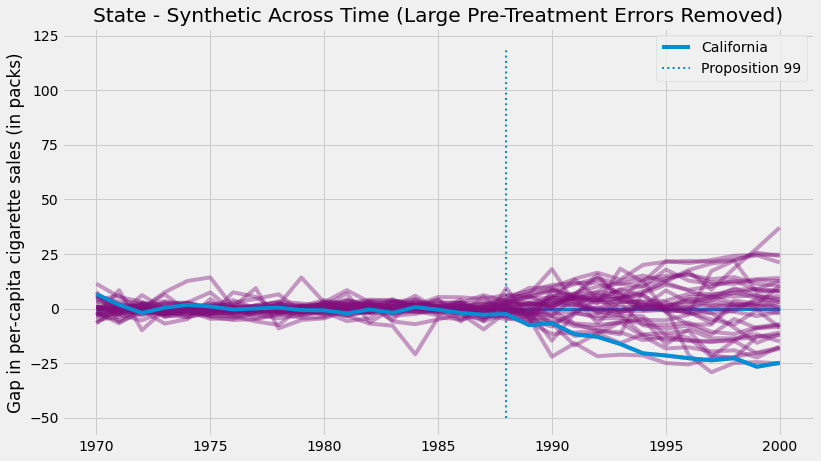

In [ ]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

잡음을 제거하면 캘리포니아 주에서 값의 영향이 얼마나 극단적인지 알 수 있습니다. 이 그림은 우리가 다른 어떤 주에서도 처치가 일어났다고 가정한다면, 캘리포니아에서 받은 것과 같은 극단적인 효과를 거의 얻지 못할 것이라는 것을 보여줍니다.

이 그림만으로도 추론의 한 형태이지만, 이 결과로부터 P-value를 도출할 수도 있습니다. 우리가 해야 할 일은 받은 영향이 캘리포니아의 영향보다 몇 배나 낮은지 확인하는 것입니다.

In [ ]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.79715887,   0.89458999, -24.83015976,  -7.16628121,
       -10.92204855,  37.1164056 , -15.06971721,  -0.49805125,
       -18.45795062,  21.13366447,  12.57782745,  -1.47547826,
        10.49627373, -11.67012352,   4.29850832,   8.04811402,
        14.023224  ,   8.25002775,   0.32576354,  -8.40826871,
        -2.12402707,  -7.42865061,   2.96157551,  24.10478137,
         4.25211766, -17.75844568,   7.93334017,   2.81640128,
        12.64955962, -17.47677514, -25.16040949, -12.26469139,
        24.69067386,  10.36299584,  -8.59880329])

캘리포니아의 효과가 0보다 작다는 단측 가설을 검정하려면 캘리포니아의 효과가 추정된 모든 효과보다 큰 비율인 P-value를 추정할 수 있습니다.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

밝혀진 바와 같이, 2000년 캘리포니아의 치료 효과는 -24.8로, 개입으로 인해 담배 소비가 거의 25갑 감소했습니다. 우리가 추정한 다른 34가지 플라시보 효과 중에서 단 하나만 캘리포니아에서 발견한 효과보다 높습니다. 따라서 P-value는 1/35가 됩니다.

In [ ]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

마지막으로 우리는 캘리포니아에서 효과의 값이 실제로 얼마나 극단적인지를 이해하기 위해 효과의 분포를 보여줄 수 있습니다.

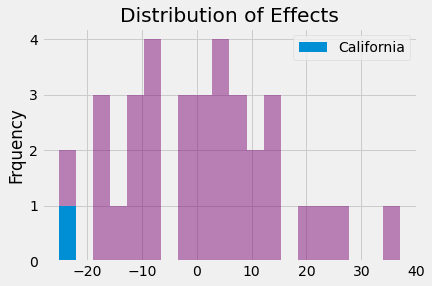

In [ ]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

## Key Ideas

우리는 도시나 주와 같은 실체에 대한 집계 수준 데이터만 있는 경우 DID를 사용하여 추론을 할 수 없다는 것을 배웠습니다. 또한 제어 집단을 정의해야 하고 하나의 제어 집단이 처치된 집단에 대한 counterfactual에 적합하지 않을 수 있기 때문에 몇 가지 다른 한계가 있습니다.

이를 수정하기 위해, 여러 제어 집단을 결합하여 처치된 집단과 유사하게 만드는 Synthetic Control을 만들 수 있다는 것을 배웠습니다. 이 Synthetic Control을 통해 우리는 처치가 없었다면 처치된 집단에 어떤 일이 일어났을지 알 수 있었습니다.

마지막으로 Fisher's Exact Tests를 사용하여 Synthetic Control을 추론하는 방법을 보았습니다. 즉, 처치되지 않은 집단이 실제로 처치된 척하고 그 효과를 계산했습니다. 이것들은 플라시보 효과였습니다. 처치 없이도 관찰할 수 있는 효과였습니다. 우리는 그것들을 사용하여 우리가 추정한 처치 효과가 통계적으로 유의한지 확인합니다.

## References

저는 이 책을 Joshua Angrist, Alberto Abadie 및 Christopher Walters의 대단한 계량 경제학 수업에 대한 찬사라고 생각하고 싶습니다. 이 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 지켜보는 것이 저의 2020년의 힘든 한 해 동안, 온전한 정신을 유지하도록 도와주었어요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)


또한 Angrist의 정말 좋은 책들을 참고자료 목록에 담고 싶습니다. 이 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 재미있다는 것을 저에게 보여주었습니다.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

제가 참고한 또다른 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자와 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

마지막으로, Scott Cunningham과 인과 추론과 Mixtape 형태를을 결합한 그의 훌륭한 작업에도 찬사를 보냅니다.

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 지적으로 접근이 가능할 수 있도록 하는 것이 목표입니다. 그리고, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/matheusfacure/python-causality-handbook/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [이 책의 Github 자료에 star](https://github.com/matheusfacure/python-causality-handbook/stargazers) 부탁드립니다!